# **Neural ODE in Surgeon Skills Classification Using Kinematics**

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

from torchdiffeq import odeint


In [2]:
# =============================
# 📌 Step 1.0: Load labels
# =============================

label_df = pd.read_csv("dataset/Knot_Tying/meta_file_Knot_Tying.txt", sep="\t", header=None, engine='python')
label_df = label_df[[0, 2]]  # keep only trial name and skill
label_df.columns = ["trial", "skill"]

# Convert 'E' to expert (1), everything else to non-expert (0)
label_df["label"] = label_df["skill"].apply(lambda x: 1 if x.strip().upper() == "E" else 0)

# Build dict: trial name -> label
label_map = dict(zip(label_df["trial"], label_df["label"]))

In [10]:
# =============================
# 📌 Step 1.1: Load & Normalize Data
# =============================

# get kinematic data
data_dir = "dataset/Knot_Tying/kinematics/AllGestures/"
# Get file paths and normalize to match operating system
file_paths = [os.path.normpath(path) for path in glob.glob(os.path.join(data_dir, "*.txt"))]
#print(file_paths)

all_trajectories = []
labels = []
scaler = StandardScaler()

for file_path in file_paths:
    df = pd.read_csv(file_path, sep=r"\s+", header=None)
    all_features = df.values
    # if the trial name is not labeled for some reason, skip
    trial_name = os.path.splitext(os.path.basename(file_path))[0]
    if trial_name not in label_map:
        continue
    # add label
    label = label_map[trial_name]
    # normalize data
    all_features = scaler.fit_transform(all_features)
    # add trajectories (X) and labels (y)
    all_trajectories.append(torch.tensor(all_features, dtype=torch.float32))
    labels.append(label)

# find longest sequence
max_len = max([seq.shape[0] for seq in all_trajectories])
# there are 76 features
features = all_features.shape[1]

# pad sequences to the max length
all_trajectories = [
    torch.cat([seq, torch.zeros(max_len - seq.shape[0], features)], dim=0)
    if seq.shape[0] < max_len else seq for seq in all_trajectories
]

# stack and convert to tensors
all_trajectories = torch.stack(all_trajectories)
labels = torch.tensor(labels)


EmptyDataError: No columns to parse from file

In [5]:
# =============================
# 📌 Step 1.2: Data generator
# =============================
class KinematicDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
# =============================
# 📌 Step 2.1: Neural ODE
# =============================

class ODEF(nn.Module):
    def __init__(self, hidden_dim):
        super(ODEF, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, t, x):
        return self.net(x)
    
class NeuralODEBlock(nn.Module):
    def __init__(self, odefunc, time_span):
        super(NeuralODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = time_span  # typically something like torch.tensor([0, 1])

    def forward(self, x):
        # expects x: [batch, hidden_dim]
        out = odeint(self.odefunc, x, self.integration_time, method='rk4')  # [2, batch, hidden_dim]
        return out[-1]  # take the final output at time t=1


In [133]:
# =============================
# 📌 Step 2.2: TCN w/ Neural ODE block
# =============================
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.relu1 = nn.ReLU()
        self.net = nn.Sequential(self.conv1, self.relu1)

    def forward(self, x):
        return self.net(x)

class TCNWithNeuralODE(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(TCNWithNeuralODE, self).__init__()
        self.tcn = TemporalBlock(input_dim, hidden_dim, kernel_size=3, stride=1, padding=2, dilation=1)

        self.odefunc = ODEF(hidden_dim)
        self.odeblock = NeuralODEBlock(self.odefunc, time_span=torch.tensor([0, 1], dtype=torch.float32))

        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)      # [B, C_in, T]
        x = self.tcn(x)             # [B, C_out, T]
        x = torch.mean(x, dim=2)    # [B, C_out]

        x = self.odeblock(x)        # [B, C_out]
        return self.fc(x)

In [134]:
# =============================
# 📌 Step 3: Combine & Prepare for TCN
# =============================
X = all_trajectories
y = labels

# Split into train/val/test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Create datasets
train_dataset = KinematicDataset(X_train, y_train)
val_dataset = KinematicDataset(X_val, y_val)
test_dataset = KinematicDataset(X_test, y_test)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

C:\Users\Jason\AppData\Local\Temp\ipykernel_39692\959224551.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
C:\Users\Jason\AppData\Local\Temp\ipykernel_39692\959224551.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)


[Epoch 0] odefunc.net.0.weight grad norm: 0.0969
[Epoch 0] odefunc.net.0.bias grad norm: 0.0717
[Epoch 0] odefunc.net.3.weight grad norm: 0.1064
[Epoch 0] odefunc.net.3.bias grad norm: 0.1091
[Epoch 0] Avg ODE delta: 0.8566
Epoch 0, Train Loss: 0.6649, Val Loss: 0.6233
[Epoch 1] odefunc.net.0.weight grad norm: 0.0698
[Epoch 1] odefunc.net.0.bias grad norm: 0.0535
[Epoch 1] odefunc.net.3.weight grad norm: 0.0773
[Epoch 1] odefunc.net.3.bias grad norm: 0.0810
[Epoch 1] Avg ODE delta: 0.8925
Epoch 1, Train Loss: 0.6385, Val Loss: 0.6020
[Epoch 2] odefunc.net.0.weight grad norm: 0.0569
[Epoch 2] odefunc.net.0.bias grad norm: 0.0398
[Epoch 2] odefunc.net.3.weight grad norm: 0.0613
[Epoch 2] odefunc.net.3.bias grad norm: 0.0515
[Epoch 2] Avg ODE delta: 0.9683
Epoch 2, Train Loss: 0.6180, Val Loss: 0.5840
[Epoch 3] odefunc.net.0.weight grad norm: 0.0500
[Epoch 3] odefunc.net.0.bias grad norm: 0.0272
[Epoch 3] odefunc.net.3.weight grad norm: 0.0536
[Epoch 3] odefunc.net.3.bias grad norm: 0.026

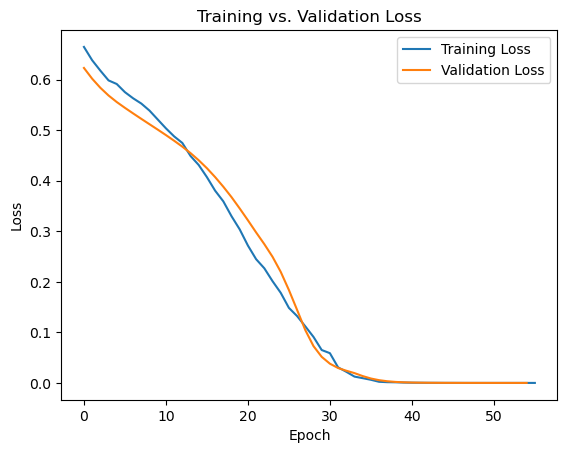

Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5

Confusion Matrix:
 [[3 0]
 [1 1]]


In [135]:
# =============================
# 📌 Step 4: Run
# =============================

# set up model
model = TCNWithNeuralODE(input_dim=features, hidden_dim=64, num_classes=2)

# use CCE and adam
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

X_train_tensor = X_train.clone().detach()
y_train_tensor = y_train.clone().detach()
X_test_tensor = X_test.clone().detach()
y_test_tensor = y_test.clone().detach()

# config early stop
best_loss = float('inf')
patience = 10
patience_counter = 0

threshold = 10.0  # You can adjust this value based on your observation of the ODE delta
delta_plateau_count = 0  # Counter to track if delta is plateauing
plateau_threshold = 2  # Delta change threshold for plateauing
max_plateau_epochs = 100  # Number of epochs to allow for plateau before stopping

train_losses = []
val_losses = []
ode_deltas = []

# run forward pass and backprop
for epoch in range(100): 
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()

    # Track ODE gradient norms
    for name, param in model.odeblock.named_parameters():
        if param.grad is not None:
            print(f"[Epoch {epoch}] {name} grad norm: {param.grad.norm():.4f}")

    optimizer.step()
    train_loss = loss.item()
    train_losses.append(train_loss)

    # Track ODE "impact" (delta) for adaptive stopping
    with torch.no_grad():
        latent_before = model.tcn(X_val.permute(0, 2, 1)).mean(dim=2)
        latent_after = model.odeblock(latent_before)
        change = torch.norm(latent_after - latent_before, dim=1).mean().item()

    print(f"[Epoch {epoch}] Avg ODE delta: {change:.4f}")

    # Check if ODE delta is growing too large
    if change > threshold:
        print(f"ODE transformation is growing too large. Stopping early.")
        break

    # Check if ODE delta is plateauing (changes very little)
    if epoch > 0 and abs(change - ode_deltas[-1]) < plateau_threshold:
        delta_plateau_count += 1
    else:
        delta_plateau_count = 0

    # If delta has plateaued for max_plateau_epochs, stop early
    if delta_plateau_count >= max_plateau_epochs:
        print(f"ODE delta has plateaued. Stopping early.")
        break

    # Store the ODE delta for further analysis (optional)
    ode_deltas.append(change)

    # Continue the regular early stopping based on validation loss (if desired)
    # validation loss monitoring
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val.clone().detach())
        val_loss = criterion(val_outputs, y_val.clone().detach()).item()

    val_loss = criterion(val_outputs, y_val.clone().detach()).item()
    val_losses.append(val_loss)
    print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_loss - 1e-4:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}")
        break

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

# evaluate model with confusion matrix
model.eval()
y_pred = model(X_test_tensor).argmax(dim=1).numpy()
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))